In [21]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import pandas as pd, seaborn as sns, io, altair as alt
alt.renderers.enable('notebook');

In [22]:
nn_p=3
# Functions
path= Path(f'../../data/cluster_results')
col_by_freq = True
col_palette = 'Set1'
pat = re.compile('.*/(exp\d)/(\w*)/nonn/freq([0-9\.]+)div(\w+)/(\w+)_\w+.csv')
decode_keys = ['experiment','function','freq','div','method']
nn_pat = re.compile('.*/(exp\d)/(\w*)/nn/freq([0-9\.]+)\w+nn_p(\d+)\w+div([A-Za-z]+)/(\w+)_(\w+)_\w+.csv')
nn_decode_keys = ['experiment','function','freq','nnp','div','method','replace_mech']

def get_files(m): return list(path.glob(f'**/nonn/**/*{m}.csv'))
def get_nn_files(m): return list(path.glob(f'**/nn/**/*{m}.csv'))

def read_csv(f,m):
    df = pd.read_csv(f)
    for k,v in zip(decode_keys,pat.search(str(f)).groups()): df[k] = v
    df['freq'] = df['freq'].astype(float)
    df['method'] = df['method'] + '_' + df['div']
    df['method'] = df['method'].str.replace('noNNRestart_No', 'noNN_Rst')
    df.drop('div', axis=1, inplace=True)
    df.rename({'0':m.upper(), m:m.upper()}, axis=1, inplace=True)
    return df

def read_nn_csv(f,m):
    df = pd.read_csv(f)
    for k,v in zip(nn_decode_keys,nn_pat.search(str(f)).groups()): df[k] = v
    df['freq'] = df['freq'].astype(float)
    df['method'] = df['method'] + '_' + df['replace_mech'] + '_' + df['div']
    df['method'] = df['method'].str.replace('NNnorm_Worst', 'NN')
    df.drop(['replace_mech','div'], axis=1, inplace=True)
    df.rename({'0':m.upper(), m:m.upper()}, axis=1, inplace=True)
    return df

def get_data(m, normalize=False):
    files = get_files(m)
    nn_files = get_nn_files(m)
    data = pd.concat([read_csv(f,m) for f in files] + [read_nn_csv(f,m) for f in nn_files])
    #this i added for remove freq 0.5 and 1
    data=data.query('freq>1')
    #added this to have nn_p=10
    data = data[data.nnp.isna() | (data.nnp == str(nn_p))].drop('nnp', axis=1)

    if normalize:
        data_norm = (data.groupby(['experiment','function','freq','method'])[m.upper()].mean().reset_index()
                         .groupby(['experiment','function'])[m.upper()].min().reset_index()
                         .rename({m.upper():m.upper()+'_norm'}, axis=1))
        data = data.merge(data_norm, 'left')
        data[m.upper()+'_norm'] = data[m.upper()] / data[m.upper()+'_norm']
    return data

def plot_one(data, m, normalize=False, title='', title_size=14, col_by_freq=col_by_freq, col_palette=col_palette,
             legend=False, hide_x=True, hide_y=True, ax=None, do_lim=True, ll=0.2, ul=0.8):
    m = m.upper()
    if normalize: m = m + '_norm' 
    if ax is None: fig,ax = plt.subplots(1,1,figsize=(6,4))
    sns.boxplot('method' if col_by_freq else 'freq', m, hue='freq' if col_by_freq else 'method',
                data=data, palette=col_palette,
                # width=2.5,
                linewidth=0.5, fliersize=0, ax=ax)
    if not legend: ax.get_legend().remove()
    if do_lim:
        ax.set_ylim(-0.05,1.05)
    else:
        g = data.groupby(['method','freq'])[m]
        q1,q3 = g.quantile(ll),g.quantile(ul)
        iqr = q3-q1
        lower_lim = (q1 - 1.5*iqr).min()
        upper_lim = (q3 + 1.5*iqr).max()
        lower_lim = data[m][data[m]>=lower_lim].min()
        upper_lim = data[m][data[m]<=upper_lim].max()
        ax.set_ylim(lower_lim,upper_lim)
        
    ax.set_xlabel('')
    if hide_x: ax.set_xticklabels([])
    if hide_y: ax.set_ylabel('')
    ax.set_title(title, size=title_size)
    return ax

def plot_all_vertical(m, normalize=False, title_size=14, col_by_freq=col_by_freq, col_palette=col_palette, do_lim=True,
                      ll=0.2, ul=0.8):
    data = get_data(m, normalize=normalize)
#     fig,axss = plt.subplots(4, 3, figsize=(14,16), sharex=do_lim, sharey=do_lim)
    fig,axss = plt.subplots(4, 3, figsize=(20,16), sharex=False, sharey=False)
    for i,(axs,exp) in enumerate(zip(axss,['exp1','exp2','exp3','exp4'])):
        first_exp = i==0
        for j,(ax,func) in enumerate(zip(axs,['sphere', 'rosenbrock', 'rastrigin'])):
            first_func = j==0
            test = data.query(f'experiment=={exp!r} and function=={func!r}').sort_values('method', ascending=False)
            plot_one(test, m, normalize=normalize, title=f'{exp}-{func.title()}', title_size=title_size, hide_x=False,
                     hide_y=not first_func, col_by_freq=col_by_freq, col_palette=col_palette, ax=ax,
                     do_lim=do_lim, ll=ll, ul=ul)
        ax.legend(loc='upper left', ncol=3)
    plt.tight_layout()
    return fig,axss

def plot_all_horizontal(m, normalize=False, title_size=14, col_by_freq=col_by_freq, col_palette=col_palette, do_lim=True,
                        ll=0.2, ul=0.8):
    data = get_data(m, normalize=normalize)
#     fig,axss = plt.subplots(4, 3, figsize=(14,16), sharex=do_lim, sharey=do_lim)
    fig,axss = plt.subplots(3, 4, figsize=(20,12), sharex=False, sharey=False)#20,12
    for i,exp in enumerate(['exp1','exp2','exp3','exp4']):
        first_exp = i==0
        axs = axss[:,i]
        for j,(ax,func) in enumerate(zip(axs,['sphere', 'rosenbrock', 'rastrigin'])):
            first_func = i==0
            test = data.query(f'experiment=={exp!r} and function=={func!r}').sort_values('method', ascending=False)
            plot_one(test, m, normalize=normalize, title=f'{exp}-{func.title()}', title_size=title_size, hide_x=False,
                     hide_y=not first_func, col_by_freq=col_by_freq, col_palette=col_palette, ax=ax,
                     do_lim=do_lim, ll=ll, ul=ul)
        
    for axs in axss: axs[-1].legend(loc='upper right', ncol=3)
    plt.tight_layout()
    return fig,axss


In [50]:
data = get_data('mof', normalize=True)

data.head()

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,MOF,experiment,freq,function,method,MOF_norm
0,0.267541,exp1,10.0,sphere,noNN_HMu,2.774506
1,0.151493,exp1,10.0,sphere,noNN_HMu,1.571037
2,0.138177,exp1,10.0,sphere,noNN_HMu,1.432952
3,0.263269,exp1,10.0,sphere,noNN_HMu,2.730200
4,0.224696,exp1,10.0,sphere,noNN_HMu,2.330186


In [34]:
mean_data = (data.groupby(['experiment','function','method'])[['MOF_norm']]
                 .mean().reset_index())

In [51]:
mean_data

,experiment,function,method,MOF_norm
0,exp1,rastrigin,NN_CwN,7.054840
1,exp1,rastrigin,NN_HMu,1.886306
2,exp1,rastrigin,NN_No,14.014499
3,exp1,rastrigin,NN_RI,1.573274
4,exp1,rastrigin,noNN_CwN,6.531369
5,exp1,rastrigin,noNN_HMu,1.974943
6,exp1,rastrigin,noNN_No,20.168405
7,exp1,rastrigin,noNN_RI,1.391080
8,exp1,rastrigin,noNN_Rst,3.129984
9,exp1,rosenbrock,NN_CwN,43.353589


In [25]:
mean_data.function=mean_data.function.str.title()
names = ['noNN_RI', 'NN_RI', 'NN_HMu', 'noNN_HMu','noNN_CwN','NN_CwN',
       'noNN_No' , 'NN_No', 'noNN_Rst']


In [53]:
mean_data.set_index('function', 'experiment', 'method')

,,experiment,method,MOF_norm
,function,,,
0,rastrigin,exp1,NN_CwN,7.054840
1,rastrigin,exp1,NN_HMu,1.886306
2,rastrigin,exp1,NN_No,14.014499
3,rastrigin,exp1,NN_RI,1.573274
4,rastrigin,exp1,noNN_CwN,6.531369
5,rastrigin,exp1,noNN_HMu,1.974943
6,rastrigin,exp1,noNN_No,20.168405
7,rastrigin,exp1,noNN_RI,1.391080
8,rastrigin,exp1,noNN_Rst,3.129984


In [18]:
def calc_data(mean_data, func, exp):
    data_final= mean_data[(mean_data.function==func) & (mean_data.experiment==exp)]
    return data_final
# data_final=calc_data(mean_data, 'Sphere', 'exp1')
# data_final2=calc_data(mean_data, 'Sphere', 'exp2')


In [8]:
funcs=['Sphere', 'Rastrigin', 'Rosenbrock']
exps= ['exp1','exp2','exp3','exp4']

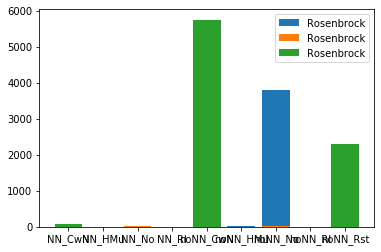

In [9]:
for fun in funcs:
    data_final = calc_data(mean_data, fun, 'exp3')
    plt.bar(data_final.method, data_final.MOF_norm, align = 'center')
    plt.legend(data_final.function)
# plt.legend(data_final.function)


In [10]:
data_final = calc_data(mean_data, 'Sphere', 'exp3')

In [11]:
data_final.MOF_norm

72      69.508409
73       2.846384
74       2.109389
75       1.880356
76     586.398522
77      29.008898
78    3788.208654
79       8.138865
80     199.423353
Name: MOF_norm, dtype: float64

In [12]:
g = sns.FacetGrid(data_final, row= data_final.MOF_norm.values, col=data_final.method )
g.map(plt.hist, "");

KeyError: "None of [Float64Index([ 69.50840890681195, 2.8463844026467946,  2.109389163706963,\n              1.8803562288051598,  586.3985224703786, 29.008897812965774,\n               3788.208654046538,  8.138864642912393, 199.42335297695743],\n             dtype='float64')] are in the [columns]"

In [27]:
chart=alt.Chart(mean_data).mark_bar(clip=True).encode(
    alt.X('method', title=''),
    alt.Y('MOF_norm', scale=alt.Scale(domain=(0,200))),
    alt.Column('experiment', title=''),
    alt.Color('function', title='', legend=alt.Legend(orient="none", legendX=550, legendY=4)), #, bbox_to_anchor=(0,0.2, 1.4, 0.8)
    alt.Tooltip(['method','MOF_norm','experiment','function'])
).properties(
    width=150,
    height=250
).configure_axisX(
    labelAngle=-45
)

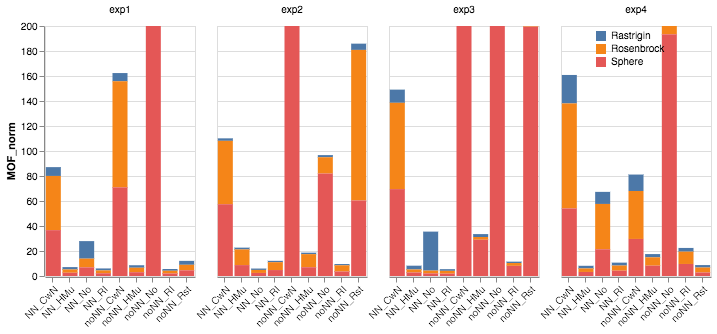

In [28]:
chart

In [19]:
#plot in different way
